# Introduction

#### This notebook will aim to analyze the interaction of Federal Funds Rate set during every Federal Open Market Commitee (FOMC) meeting, with the Standards and Poors 500 (S&P500) index. <br> The S&P500 Index was chosen to help demonstrate the interaction with majority of the stock market. The notebook will observe the effect of changing interests rate on the market, and if different sentiments (hawkish, doveish, hold) affect the stock market differently. <br>

### Section 1: Import and Prepare Data for Analysis <br>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from statsmodels.nonparametric.smoothers_lowess import lowess
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
fedrates = pd.read_excel("FedFunds.xlsx")
fedrates= fedrates.loc[fedrates.Date > pd.to_datetime('1962-01-01')]

In [3]:
fedrates.head()

,Date,Rate
91,1962-02-01,2.37
92,1962-03-01,2.85
93,1962-04-01,2.78
94,1962-05-01,2.36
95,1962-06-01,2.68


In [4]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697 entries, 91 to 787
Data columns (total 2 columns):
Date    697 non-null datetime64[ns]
Rate    697 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.3 KB


In [5]:
feddates = pd.read_excel("FOMCDates.xlsx")
feddates = feddates.loc[feddates.begdate > pd.to_datetime('1962-01-01')]

In [6]:
feddates.head()

,begdate,scheduled,document,url
138,1962-01-09,1,Record of Policy Actions (429 KB PDF),/monetarypolicy/files/fomcropa19620109.pdf
139,1962-01-23,1,Record of Policy Actions (334 KB PDF),/monetarypolicy/files/fomcropa19620123.pdf
140,1962-02-13,1,Record of Policy Actions (699 KB PDF),/monetarypolicy/files/fomcropa19620213.pdf
141,1962-03-06,1,Record of Policy Actions (528 KB PDF),/monetarypolicy/files/fomcropa19620306.pdf
142,1962-03-27,1,Record of Policy Actions (338 KB PDF),/monetarypolicy/files/fomcropa19620327.pdf


In [7]:
feddates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 138 to 857
Data columns (total 4 columns):
begdate      720 non-null datetime64[ns]
scheduled    720 non-null int64
document     672 non-null object
url          629 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 28.1+ KB


In [8]:
feddates = feddates.drop(['document','url'],axis=1)

#### Since both date fields are already datetime format, we can split it by month and year and merge the two datasets and then drop the date column from fedrates since it is monthly data <br>

In [9]:
fedrates['month'] = fedrates['Date'].dt.month
feddates['month'] = feddates['begdate'].dt.month

fedrates['year'] = fedrates['Date'].dt.year
feddates['year'] = feddates['begdate'].dt.year

In [10]:
feddates.head()

,begdate,scheduled,month,year
138,1962-01-09,1,1,1962
139,1962-01-23,1,1,1962
140,1962-02-13,1,2,1962
141,1962-03-06,1,3,1962
142,1962-03-27,1,3,1962


In [11]:
fedrates.head()

,Date,Rate,month,year
91,1962-02-01,2.37,2,1962
92,1962-03-01,2.85,3,1962
93,1962-04-01,2.78,4,1962
94,1962-05-01,2.36,5,1962
95,1962-06-01,2.68,6,1962


In [12]:
fed_funds_data = feddates.merge(fedrates, on=['month','year'])

In [13]:
fed_funds_data.head(10)

,begdate,scheduled,month,year,Date,Rate
0,1962-02-13,1,2,1962,1962-02-01,2.37
1,1962-03-06,1,3,1962,1962-03-01,2.85
2,1962-03-27,1,3,1962,1962-03-01,2.85
3,1962-04-17,1,4,1962,1962-04-01,2.78
4,1962-05-08,1,5,1962,1962-05-01,2.36
5,1962-05-29,1,5,1962,1962-05-01,2.36
6,1962-06-19,1,6,1962,1962-06-01,2.68
7,1962-06-21,0,6,1962,1962-06-01,2.68
8,1962-07-10,1,7,1962,1962-07-01,2.71
9,1962-07-31,1,7,1962,1962-07-01,2.71


In [14]:
fed_funds_data.drop(['month','year','Date'],axis=1,inplace=True)

In [15]:
fed_funds_data.columns = ['MeetingDate', 'WasScheduled?', 'DecidedRate']

In [16]:
fed_funds_data['PreviousRate'] = fed_funds_data['DecidedRate'].shift(1,axis=0)

In [17]:
fed_funds_data['NextRate'] = fed_funds_data['DecidedRate'].shift(-1, axis=0)

In [18]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate
0,1962-02-13,1,2.37,NaN,2.85
1,1962-03-06,1,2.85,2.37,2.85
2,1962-03-27,1,2.85,2.85,2.78
3,1962-04-17,1,2.78,2.85,2.36
4,1962-05-08,1,2.36,2.78,2.36


In [19]:
SP500 = pd.read_excel("SP500Data.xlsx")
SP500 = SP500.loc[SP500.Date > pd.to_datetime('1962-01-01')]

In [20]:
SP500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2014,1962-01-02,71.550003,71.959999,70.709999,70.959999,70.959999,3120000
2015,1962-01-03,70.959999,71.480003,70.379997,71.129997,71.129997,3590000
2016,1962-01-04,71.129997,71.620003,70.449997,70.639999,70.639999,4450000
2017,1962-01-05,70.639999,70.839996,69.349998,69.660004,69.660004,4630000
2018,1962-01-08,69.660004,69.839996,68.169998,69.120003,69.120003,4620000


In [21]:
sns.set(rc={'figure.figsize':(12,9)})

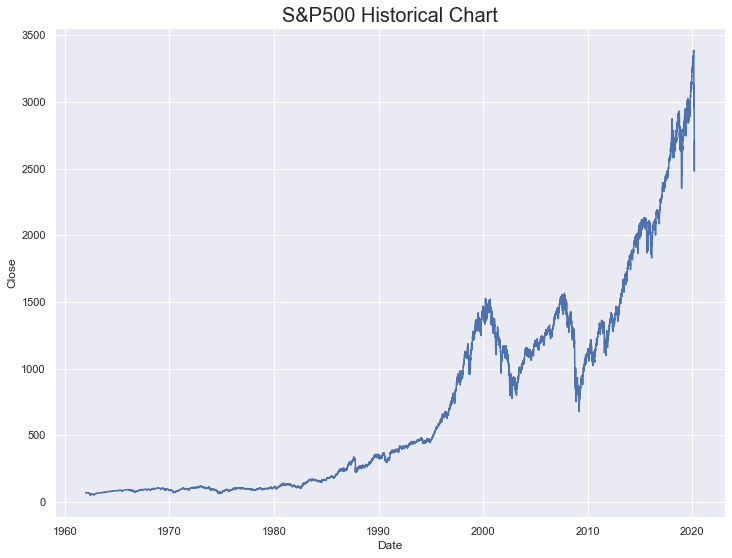

In [22]:
ax1= sns.lineplot(x='Date', y='Close', data=SP500).set_title('S&P500 Historical Chart', size=20)

### Section 2: Process Dataset<br>

In [23]:
def find_sentiment(data):
    if (data['DecidedRate'] >  data['PreviousRate']) & (data['DecidedRate']- data['PreviousRate'] > 0.09):
        return 'Hawkish'
    elif (data['DecidedRate'] < data['PreviousRate']) & (data['PreviousRate'] - data['DecidedRate'] > 0.09):
        return 'Doveish'
    else:
        return 'Hold'
    

In [24]:
fed_funds_data['Sentiment'] = fed_funds_data.apply(find_sentiment, axis=1)

Text(0.5, 1.0, 'Count of Fed Decision and Associated Sentiment')

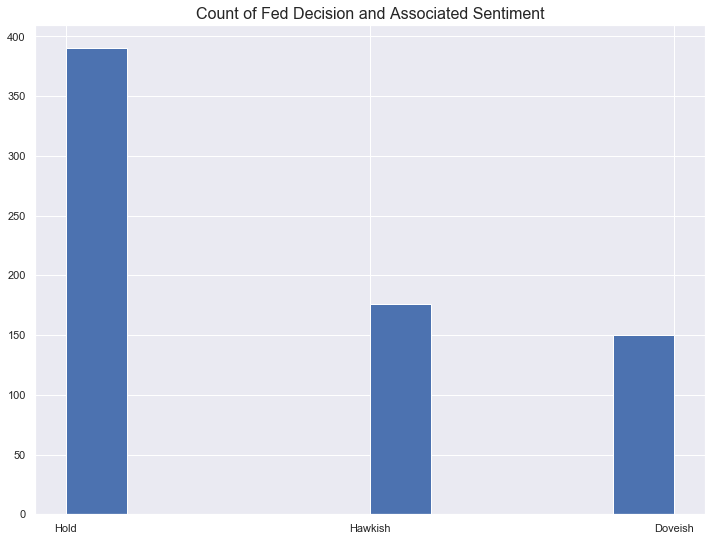

In [25]:
fed_funds_data.Sentiment.hist()
plt.title("Count of Fed Decision and Associated Sentiment", size =16)

In [26]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate,Sentiment
0,1962-02-13,1,2.37,NaN,2.85,Hold
1,1962-03-06,1,2.85,2.37,2.85,Hawkish
2,1962-03-27,1,2.85,2.85,2.78,Hold
3,1962-04-17,1,2.78,2.85,2.36,Hold
4,1962-05-08,1,2.36,2.78,2.36,Doveish


Hawkish    343 <br>
Doveish    275 <br>
Hold       238 <br>

In [27]:
SP500['MaxShift'] = abs(SP500['Low'] - SP500['High'])/SP500['Open']*100
SP500['DailyVolatility'] = (SP500['Close'] - SP500['Open'])/SP500['Open']*100

In [28]:
SP500['MaxShift'].describe()

count    14650.000000
mean         1.400846
std          0.848945
min          0.000000
25%          0.824934
50%          1.289728
75%          1.761339
max         20.470466
Name: MaxShift, dtype: float64

In [29]:
SP500['DailyVolatility'].describe()

count    14650.000000
mean         0.028458
std          0.975410
min        -20.466931
25%         -0.411940
50%          0.040981
75%          0.489134
max         10.789006
Name: DailyVolatility, dtype: float64

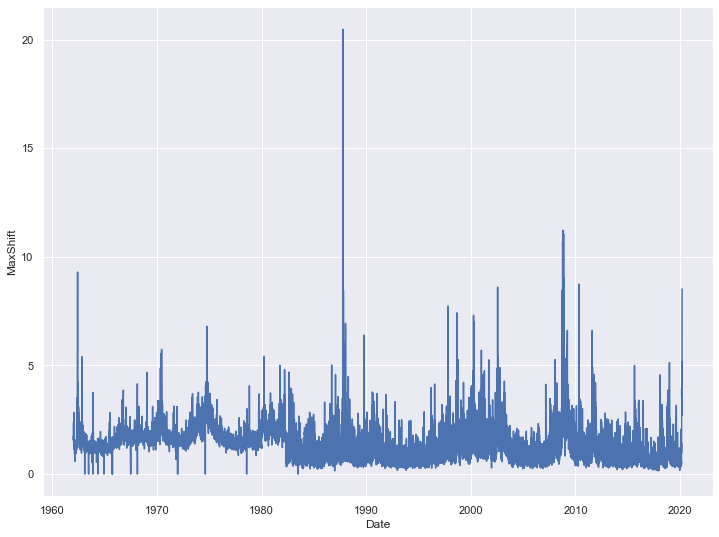

In [30]:
sns.lineplot(x='Date', y='MaxShift', data=SP500, legend='full')

Text(0.5, 1.0, 'S&P500 Daily Volatility')

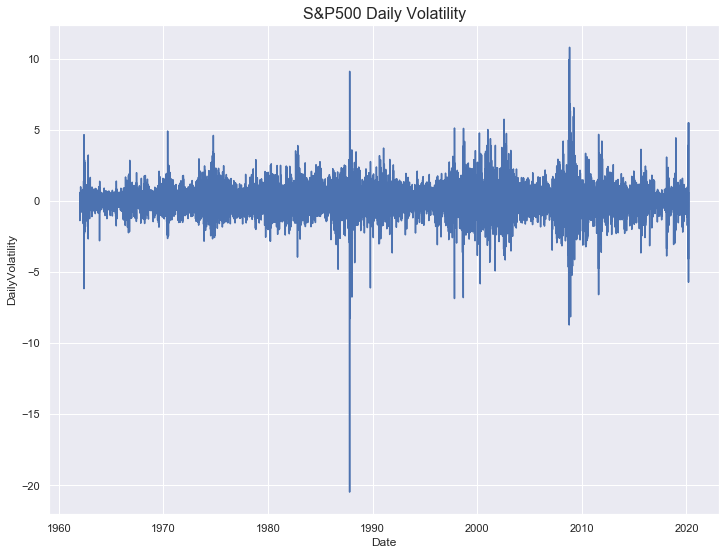

In [31]:
sns.lineplot(x='Date', y='DailyVolatility', data=SP500).set_title("S&P500 Daily Volatility", size=16)

In [32]:
vertical_lines_hold = fed_funds_data[fed_funds_data['Sentiment']=='Hold']['MeetingDate']
vertical_lines_dove = fed_funds_data[fed_funds_data['Sentiment']=='Doveish']['MeetingDate']
vertical_lines_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hawkish']['MeetingDate']

In [33]:
from matplotlib.backends.backend_pdf import PdfPages

In [34]:
with PdfPages('SPY_FedFundsRate_Trends.pdf') as pdf:
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_dove:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Doveish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hawk:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hawkish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [35]:
SP500['PrevDayVolatility'] = SP500['DailyVolatility'].shift(1,axis=0)
SP500['PrevDayMaxShift'] = SP500['MaxShift'].shift(1,axis=0)
SP500['NextDayVolatility'] = SP500['DailyVolatility'].shift(-1,axis=0)
SP500['NextDayMaxShift'] = SP500['MaxShift'].shift(-1,axis=0)
SP500['AvgVolatility'] = (SP500['PrevDayVolatility'] + SP500['DailyVolatility'] + SP500['NextDayVolatility'])/3
SP500['AvgAbsVolatility'] = abs((SP500['DailyVolatility']))
SP500['ThreeDayAvgAbsVolatility'] = abs((SP500['PrevDayVolatility'] + SP500['DailyVolatility'] + SP500['NextDayVolatility']))/3
SP500['AvgMaxShift'] = (SP500['PrevDayMaxShift'] + SP500['MaxShift'] + SP500['NextDayMaxShift'])/3

In [36]:
SPY_dove_trend = SP500.merge(vertical_lines_dove, left_on='Date', right_on='MeetingDate')
SPY_hawk_trend = SP500.merge(vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
SPY_hold_trend = SP500.merge(vertical_lines_hold, left_on='Date', right_on='MeetingDate')

In [37]:
SPY_dove_trend.shape

(149, 18)

In [38]:
SPY_hawk_trend.shape

(176, 18)

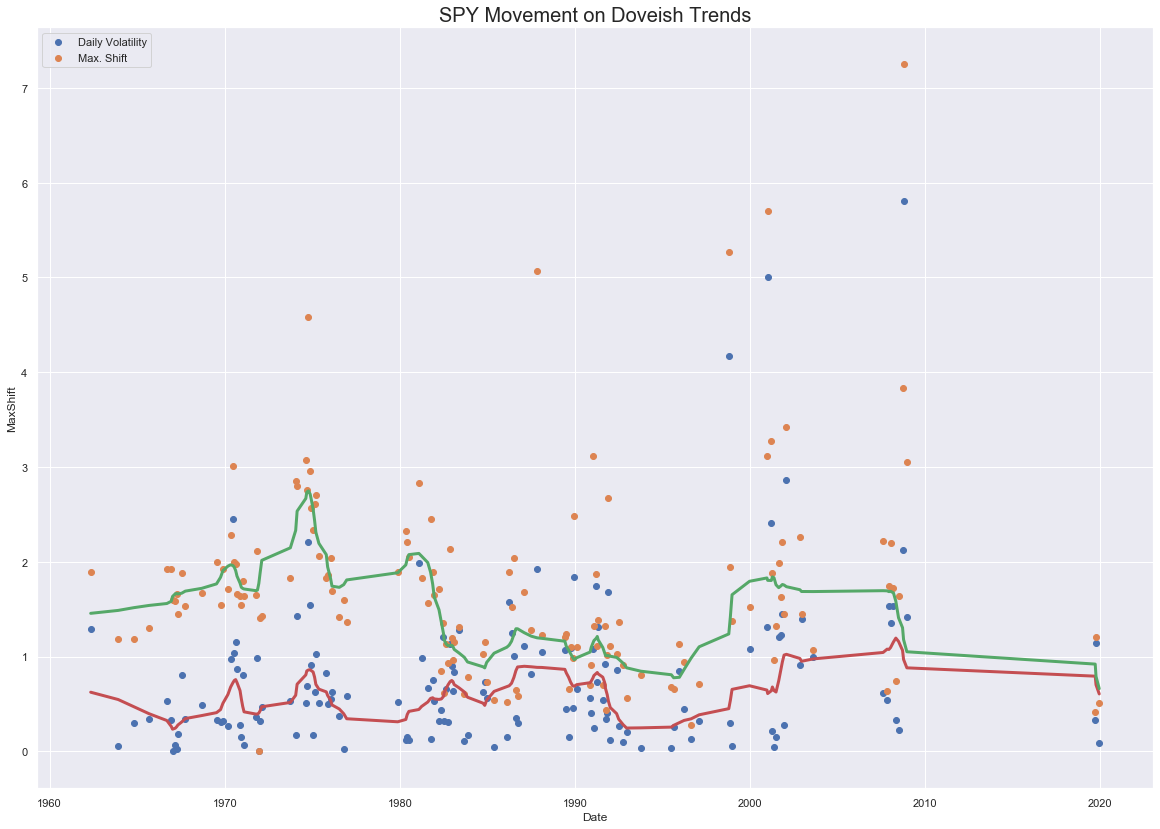

In [39]:
sns.set(rc={'figure.figsize':(20,14)})
#X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
Y = plt.scatter(SPY_dove_trend['Date'], SPY_dove_trend['AvgAbsVolatility'], label= 'Daily Volatility')
Z = plt.scatter(SPY_dove_trend['Date'], SPY_dove_trend['MaxShift'], label = 'Max. Shift')

rSPYplot = SPY_dove_trend.set_index('Date')
loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r', legend = 'brief')
loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g', legend= 'brief')
plt.legend(loc = "upper left")
plt.title("SPY Movement on Doveish Trends", fontsize = '20')
plt.show()

In [40]:
with PdfPages('SPY_SentimentMovement_Trends.pdf') as pdf:
    #X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.scatter(SPY_dove_trend['Date'], SPY_dove_trend['AvgAbsVolatility'], label= 'Daily Volatility')
    Z = plt.scatter(SPY_dove_trend['Date'], SPY_dove_trend['MaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Doveish Trends", fontsize = '20')
    
    rSPYplot = SPY_dove_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    
    #X = plt.plot(SPY_hawk_trend['Date'], SPY_hawk_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.scatter(SPY_hawk_trend['Date'], SPY_hawk_trend['AvgAbsVolatility'], label= 'Daily Volatility')
    Z = plt.scatter(SPY_hawk_trend['Date'], SPY_hawk_trend['MaxShift'], label = 'Max. Shift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hawkish Trends", fontsize = '20')
    
    rSPYplot = SPY_hawk_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
        
    #X = plt.plot(SPY_hold_trend['Date'], SPY_hold_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.scatter(SPY_hold_trend['Date'], SPY_hold_trend['AvgAbsVolatility'], label= 'Daily Volatility')
    Z = plt.scatter(SPY_hold_trend['Date'], SPY_hold_trend['MaxShift'], label = 'Max. Shift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Holding Trends", fontsize = '20')
    
    rSPYplot = SPY_hold_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------

## Section: Split Datasets into different time periods and see Fed Decision trends across these time periods. Recession dates are incorrect since it took all dates. Learning experience.

In [41]:
#import recession dates from https://fred.stlouisfed.org/series/JHDUSRGDPBR
recessions = pd.read_excel("US_recessions.xlsx")

In [42]:
recessions['Date'] = pd.to_datetime(recessions['Date'])
recessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19358 entries, 0 to 19357
Data columns (total 2 columns):
Date                 19358 non-null datetime64[ns]
IsRecessionLikely    19358 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 302.6 KB


In [43]:
recession_dates = recessions.loc[recessions['IsRecessionLikely']==1]
recession_dates.head()

,Date,IsRecessionLikely
821,1969-04-01,1
822,1969-04-02,1
823,1969-04-03,1
824,1969-04-04,1
825,1969-04-05,1


In [44]:
SP500_recessions = SP500.merge(recession_dates, left_on='Date', right_on='Date')
SP500_recessions.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MaxShift,DailyVolatility,PrevDayVolatility,PrevDayMaxShift,NextDayVolatility,NextDayMaxShift,AvgVolatility,AvgAbsVolatility,ThreeDayAvgAbsVolatility,AvgMaxShift,IsRecessionLikely
0,1969-04-01,101.510002,102.449997,100.839996,101.419998,101.419998,12360000,1.586052,-0.088665,0.405543,1.602369,-0.631038,1.025440,-0.104720,0.088665,0.104720,1.404620,1
1,1969-04-02,101.419998,101.650002,100.610001,100.779999,100.779999,10110000,1.025440,-0.631038,-0.088665,1.586052,-0.099225,1.418932,-0.272976,0.631038,0.272976,1.343475,1
2,1969-04-03,100.779999,101.300003,99.870003,100.680000,100.680000,10300000,1.418932,-0.099225,-0.631038,1.025440,-0.735365,1.540291,-0.488543,0.099225,0.488543,1.328221,1
3,1969-04-07,100.629997,100.629997,99.080002,99.889999,99.889999,9430000,1.540291,-0.735365,-0.099225,1.418932,0.250275,1.922113,-0.194772,0.735365,0.194772,1.627112,1
4,1969-04-08,99.889999,101.269997,99.349998,100.139999,100.139999,9360000,1.922113,0.250275,-0.735365,1.540291,0.878768,1.557824,0.131226,0.250275,0.131226,1.673410,1


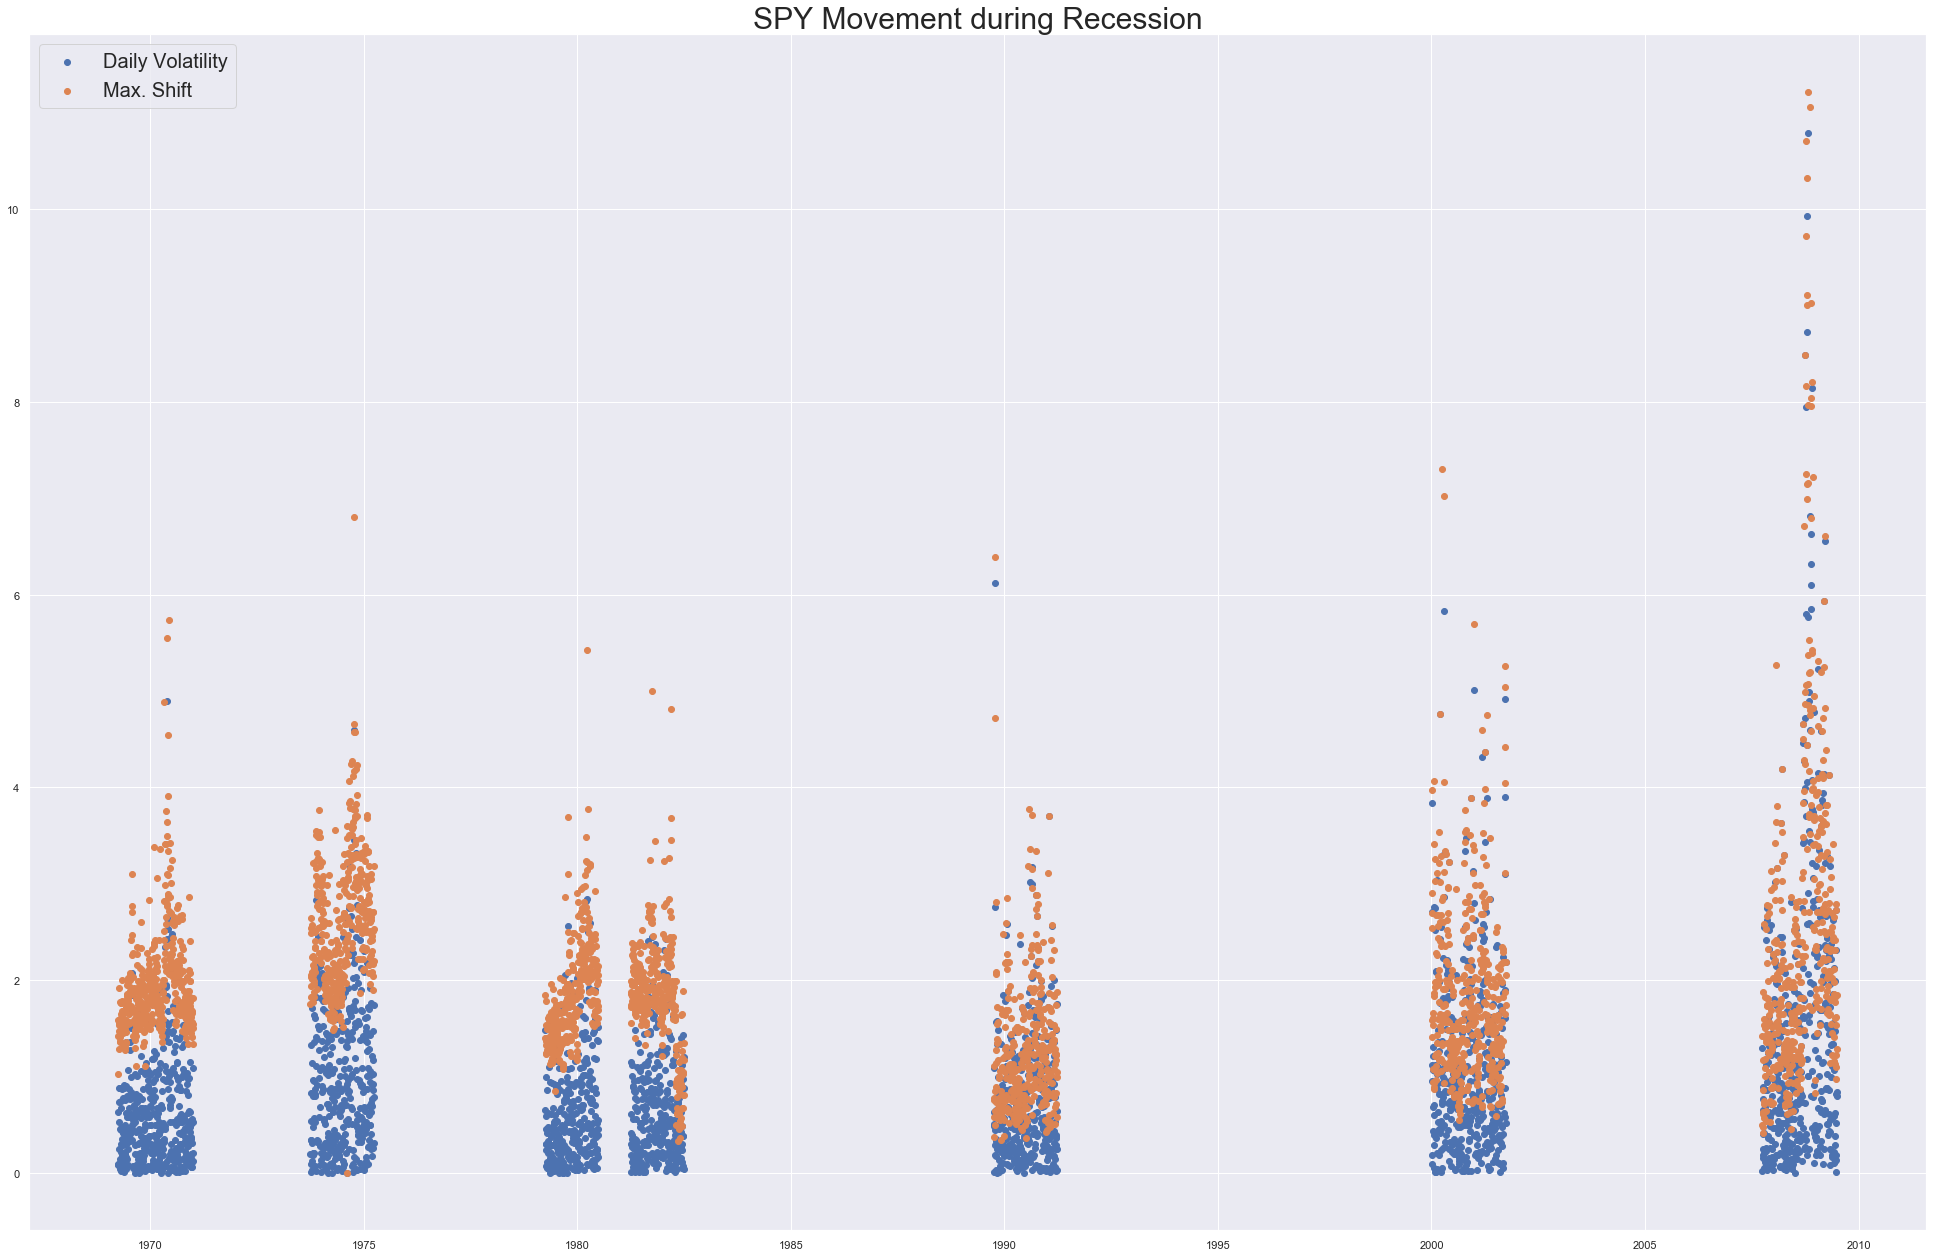

In [45]:
sns.set(rc={'figure.figsize':(34,22)})
X = plt.scatter(SP500_recessions['Date'], SP500_recessions['AvgAbsVolatility'], label="Daily Volatility")
Z = plt.scatter(SP500_recessions['Date'], SP500_recessions['MaxShift'], label = 'Max. Shift')
plt.legend(loc = "upper left", fontsize='20')
plt.title("SPY Movement during Recession", fontsize = '30')
plt.show()

In [46]:
Recession_SPY_dove_trend = SP500_recessions.merge(vertical_lines_dove, left_on='Date', right_on='MeetingDate')
Recession_SPY_hawk_trend = SP500_recessions.merge(vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
Recession_SPY_hold_trend = SP500_recessions.merge(vertical_lines_hold, left_on='Date', right_on='MeetingDate')

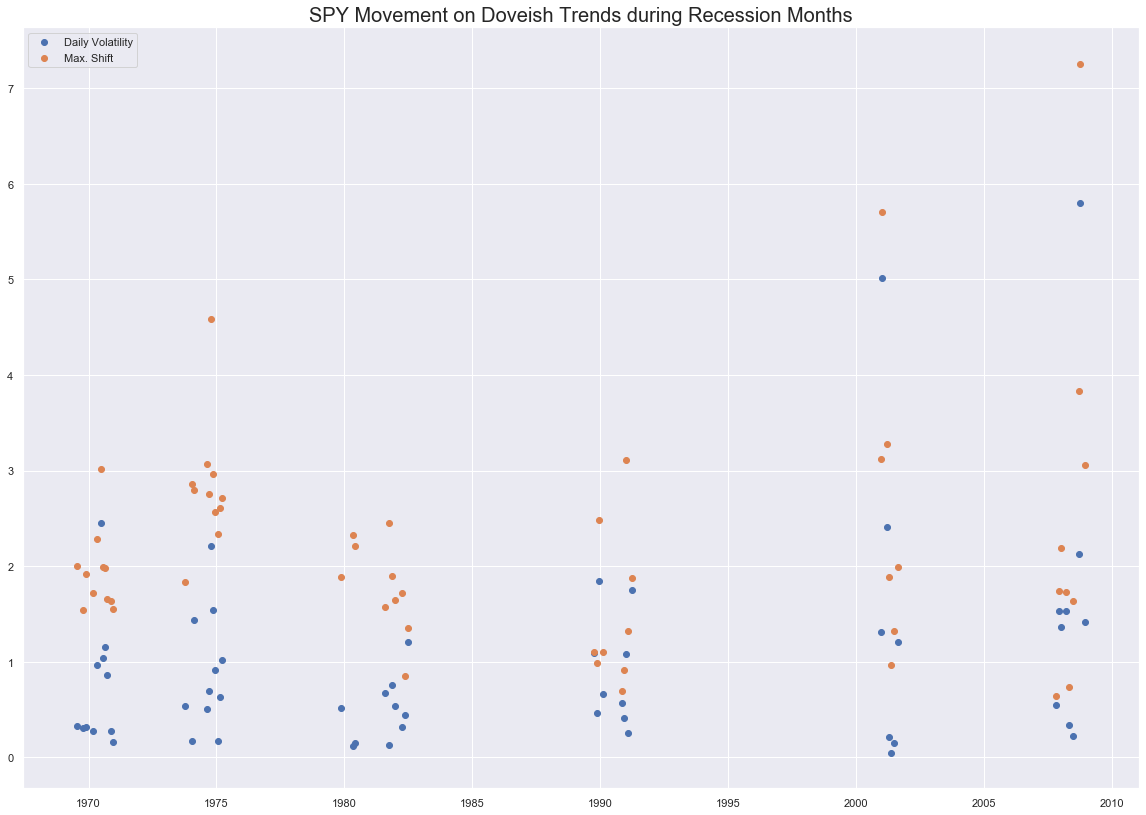

In [61]:
sns.set(rc={'figure.figsize':(20,14)})
X = plt.scatter(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['AvgAbsVolatility'], label="Daily Volatility")
Y = plt.scatter(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['MaxShift'], label="Max. Shift")
plt.legend(loc = "upper left")
plt.title("SPY Movement on Doveish Trends during Recession Months", fontsize = '20')
plt.show()

In [48]:
with PdfPages('SPY_Recession_SentimentMovement_Trends.pdf') as pdf:
    X = plt.scatter(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    
    rSPYplot = Recession_SPY_dove_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    plt.title("SPY Movement on Doveish Trends during Recession Months", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(Recession_SPY_hawk_trend['Date'], Recession_SPY_hawk_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(Recession_SPY_hawk_trend['Date'], Recession_SPY_hawk_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hawkish Trends during Recession Months", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(Recession_SPY_hold_trend['Date'], Recession_SPY_hold_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(Recession_SPY_hold_trend['Date'], Recession_SPY_hold_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Holding Trends during Recession Months", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

#### Post Recession: Check movement during unscheduled Fed meetings

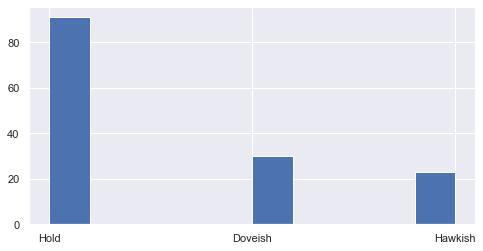

In [49]:
sns.set(rc={'figure.figsize':(8,4)})
unscheduled_fed = fed_funds_data.loc[fed_funds_data['WasScheduled?']==0]
unscheduled_fed.Sentiment.hist()

In [50]:
unsch_vertical_lines_hold = unscheduled_fed[unscheduled_fed['Sentiment']=='Hold']['MeetingDate']
unsch_vertical_lines_dove = unscheduled_fed[unscheduled_fed['Sentiment']=='Doveish']['MeetingDate']
unsch_vertical_lines_hawk = unscheduled_fed[unscheduled_fed['Sentiment']=='Hawkish']['MeetingDate']

In [51]:
unsch_SPY_dove_trend = SP500.merge(unsch_vertical_lines_dove, left_on='Date', right_on='MeetingDate')
unsch_SPY_hawk_trend = SP500.merge(unsch_vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
unsch_SPY_hold_trend = SP500.merge(unsch_vertical_lines_hold, left_on='Date', right_on='MeetingDate')

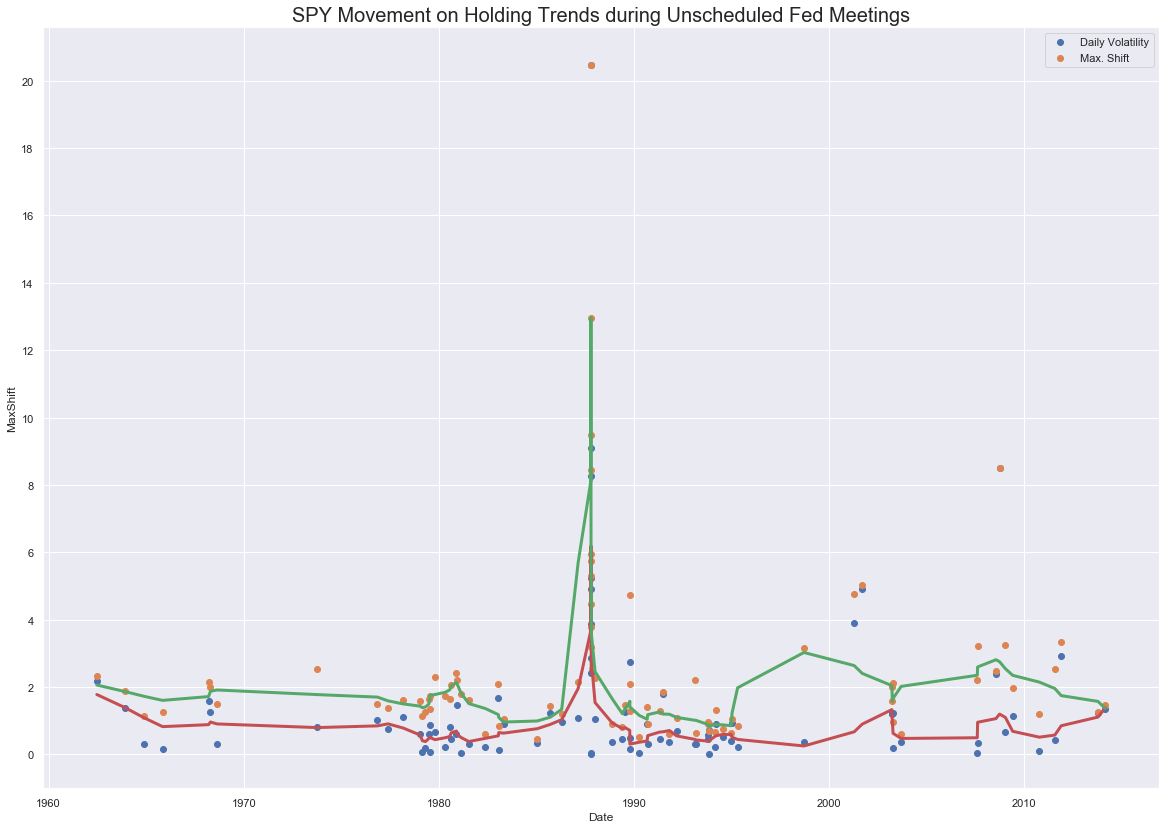

In [64]:
sns.set(rc={'figure.figsize':(20, 14)})
X = plt.scatter(unsch_SPY_hold_trend['Date'], unsch_SPY_hold_trend['AvgAbsVolatility'], label="Daily Volatility")
Y = plt.scatter(unsch_SPY_hold_trend['Date'], unsch_SPY_hold_trend['MaxShift'], label="Max. Shift")
plt.legend(loc = "upper left")
rSPYplot = unsch_SPY_hold_trend.set_index('Date')
loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
plt.yticks([0,2,4,6,8,10,12,14,16,18,20])
plt.title("SPY Movement on Holding Trends during Unscheduled Fed Meetings", fontsize = '20')
plt.show()

In [53]:
with PdfPages('SPY_Unscheduled_SentimentMovement_Trends.pdf') as pdf:
    X = plt.scatter(unsch_SPY_dove_trend['Date'], unsch_SPY_dove_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(unsch_SPY_dove_trend['Date'], unsch_SPY_dove_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Doveish Trends during Unscheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(unsch_SPY_hawk_trend['Date'], unsch_SPY_hawk_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(unsch_SPY_hawk_trend['Date'], unsch_SPY_hawk_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hawkish Trends during Unscheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(unsch_SPY_hold_trend['Date'], unsch_SPY_hold_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(unsch_SPY_hold_trend['Date'], unsch_SPY_hold_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    rSPYplot = unsch_SPY_hold_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    plt.title("SPY Movement on Holding Trends during Unscheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

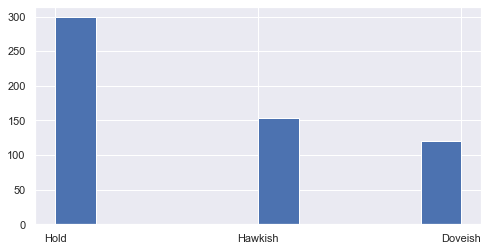

In [54]:
sns.set(rc={'figure.figsize':(8,4)})
scheduled_fed = fed_funds_data.loc[fed_funds_data['WasScheduled?']==1]
scheduled_fed.Sentiment.hist()

In [55]:
sch_vertical_lines_hold = scheduled_fed[scheduled_fed['Sentiment']=='Hold']['MeetingDate']
sch_vertical_lines_dove = scheduled_fed[scheduled_fed['Sentiment']=='Doveish']['MeetingDate']
sch_vertical_lines_hawk = scheduled_fed[scheduled_fed['Sentiment']=='Hawkish']['MeetingDate']

sch_SPY_dove_trend = SP500.merge(sch_vertical_lines_dove, left_on='Date', right_on='MeetingDate')
sch_SPY_hawk_trend = SP500.merge(sch_vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
sch_SPY_hold_trend = SP500.merge(sch_vertical_lines_hold, left_on='Date', right_on='MeetingDate')

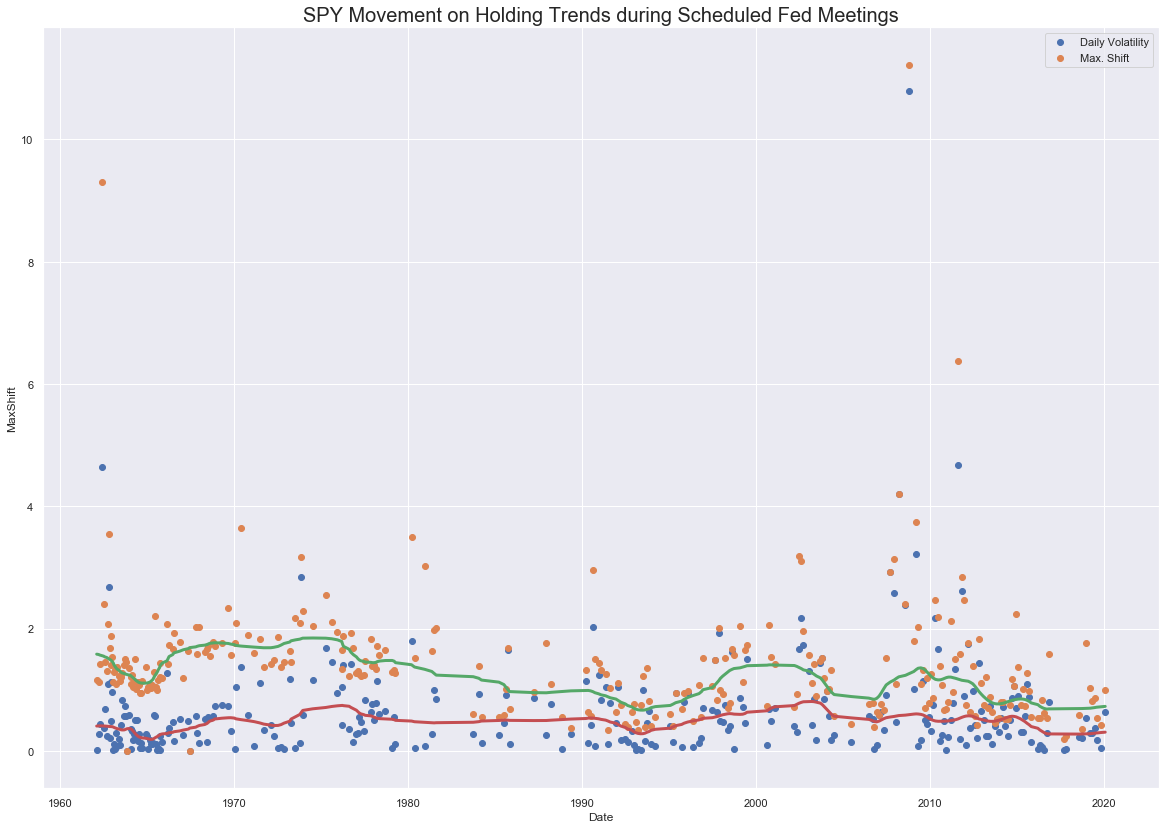

In [63]:
sns.set(rc={'figure.figsize':(20, 14)})
#X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
X = plt.scatter(sch_SPY_hold_trend['Date'], sch_SPY_hold_trend['AvgAbsVolatility'], label="Daily Volatility")
Y = plt.scatter(sch_SPY_hold_trend['Date'], sch_SPY_hold_trend['MaxShift'], label="Max. Shift")
plt.legend(loc = "upper left")

rSPYplot = sch_SPY_hold_trend.set_index('Date')
loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
plt.title("SPY Movement on Holding Trends during Scheduled Fed Meetings", fontsize = '20')
plt.show()

In [57]:
with PdfPages('SPY_Scheduled_SentimentMovement_Trends.pdf') as pdf:
    X = plt.scatter(sch_SPY_dove_trend['Date'], sch_SPY_dove_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(sch_SPY_dove_trend['Date'], sch_SPY_dove_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    
    rSPYplot = sch_SPY_dove_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    plt.title("SPY Movement on Doveish Trends during Scheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(sch_SPY_hawk_trend['Date'], sch_SPY_hawk_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(sch_SPY_hawk_trend['Date'], sch_SPY_hawk_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    
    rSPYplot = sch_SPY_hawk_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    plt.title("SPY Movement on Hawkish Trends during Scheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    X = plt.scatter(sch_SPY_hold_trend['Date'], sch_SPY_hold_trend['AvgAbsVolatility'], label="Daily Volatility")
    Y = plt.scatter(sch_SPY_hold_trend['Date'], sch_SPY_hold_trend['MaxShift'], label="Max. Shift")
    plt.legend(loc = "upper left")
    rSPYplot = sch_SPY_hold_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g')
    plt.title("SPY Movement on Holding Trends during Scheduled Fed Meetings", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

### Section: Overlaying Smoothed Graphs to observe trends for each given time-frame <br>

In [58]:
SP500 = SP500.iloc[1:-1]

In [59]:
SP500.shape

(14648, 17)

([<matplotlib.axis.YTick at 0x1a1db85c10>,
 <a list of 11 Text yticklabel objects>)

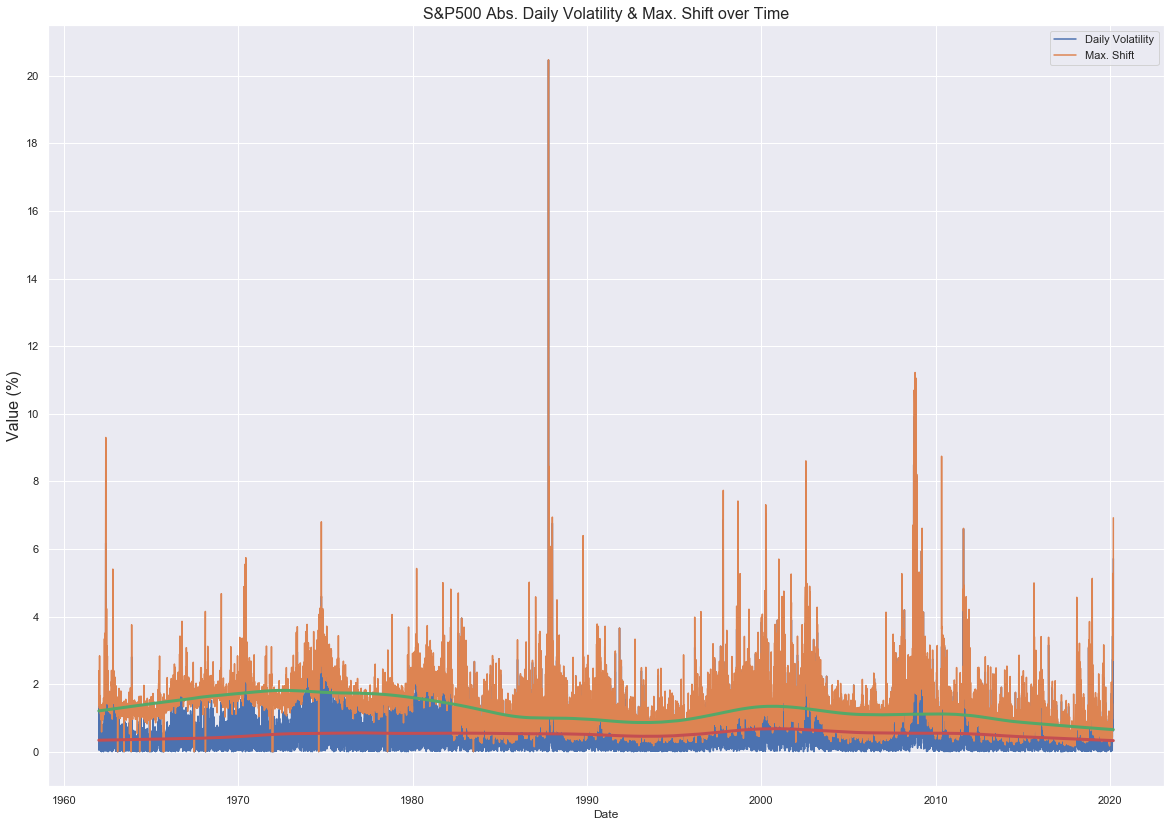

In [60]:
sns.set(rc={'figure.figsize':(20, 14)})
#X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
Y = plt.plot(SP500['Date'], SP500['AvgAbsVolatility'], label= 'Daily Volatility')
Z = plt.plot(SP500['Date'], SP500['MaxShift'], label = 'Max. Shift')

rSPYplot = SP500.set_index('Date')
loess_x = pd.DataFrame(lowess(rSPYplot['AvgAbsVolatility'], np.arange(len(rSPYplot['AvgAbsVolatility'])), frac=0.2)[:, 1], index=rSPYplot.index, columns=['AvgAbsVolatility'])
sns.lineplot(x = rSPYplot.index, y = 'AvgAbsVolatility', linewidth = 3, data = loess_x, color='r')
loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.2)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='g', legend = 'full').set_title("S&P500 Abs. Daily Volatility & Max. Shift over Time", size=16)
plt.ylabel('Value (%)', fontsize=16)
plt.yticks([0,2,4,6,8,10,12,14,16,18,20])